# CAMB Power Spectra

In this notebook, I demonstrate manipulations of powerspectra constructed using [CAMB](https://camb.readthedocs.io/en/latest/) (Code for Anisotropies in the Microwave Background) and those read from the `peakpatch/tables/` directory. These are compared with power spectra from the literature to demonstrate the units and conventions of *Peak Patch* and *WebSky*.

In [1]:
# Core python modules
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# For displaying python output in markdown
from IPython.display import display, Markdown

# Cosmology
import astropy.units as u
from astropy.cosmology import Planck18,z_at_value
import camb
from camb import model, initialpower

# Fitting smoothing and integration
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import scipy.optimize as optimize

# Command line manipulation
import os

## Simulation parameters
Parameters for the simulations are based on the *Planck* Collaboration results from 2018 [[1807.06209](https://arxiv.org/abs/1807.06209)].

In [2]:
##############################
###   Physical constants   ###
##############################

# speed of light (km/s)
c = 2.99792458e5 * u.km/u.s

###################################
###   Cosmological parameters   ###
###################################
# following Planck 2018 results

# reduced Hubble constant
h = 0.6735

# Hubble constant (km/s/Mpc)
H_0 = 100*h * u.km/u.s/u.Mpc

# baryon density fraction
Omega_b = 0.0493

# DM density fraction
Omega_X = 0.2645

# matter density fraction
Omega_m = Omega_b + Omega_X

# curvature
Omega_k = 0.0

# sigma_8
sigma_8 = 0.8111

# massive neutrino mass
m_nu = 0.0

# optical depth of reionization
tau = 0.0544

# scalar spectral index
n_s = 0.9649

# primordial super-horizon comoving curvature power spectrum amplitude
A_s = 2.100e-9

#####################################
###   Power spectrum parameters   ###
#####################################

# Range of wavenumbers to be used
kmax_h   = 1.0e3/h  # max wavenumber / h
kmin_h   = 2.0e-5/h # min wavenumber / h
nkpoints = 100      # number of points in power spectra tables

## CAMB power spectrum
Setting up cosmology and determining the power spectrum with CAMB.

In [45]:
#############################
###  Set CAMB cosmology   ###
#############################

# Make CAMB parameter object
pars = camb.CAMBparams()

# Set cosmology
pars.set_cosmology( H0    = H_0.value   , # Hubble constant, dln(a)/dt at present
                    ombh2 = Omega_b*h**2, # comoving baryon energy density fraction
                    omch2 = Omega_X*h**2, # comoving dark matter energy density fraction
                    mnu   = m_nu        , # massive neutrino mass
                    omk   = Omega_k     , # curvature energy density fraction
                    tau   = tau         ) # optical depth of reionization

# Set Lambda model
pars.set_dark_energy( w   = -1.0, # equation of state w = p_\Lambda / \rho_\Lambda
                      cs2 = 1.0 , # rest-frame sound speed squared of dark energy fluid
                      wa  = 0   , # evolution of w
                      dark_energy_model='fluid')

# Set parameters for primordial power spectrum calculation
pars.InitPower.set_params( ns = n_s , # scalar spectral index
                           As = A_s ) # primordial spectrum amplitude

# Set parameters for matter power spectrum calculation
pars.set_matter_power(redshifts=[0.0], kmax=kmax_h*h)
pars.NonLinear = model.NonLinear_none # linear matter power spectrum only

# Set parameters for transfer function calculation
pars.PK_WantTransfer = 1 # Tell CAMB to calculate the matter
pars.WantTransfer    = 1 #     power transfer function
pars.Transfer.kmax   = kmax_h*h # Maximum wavenumber for transfer function

###################################
###   Calculate Power Spectra   ###
###################################

# Calculate results for specified parameters
results = camb.get_results(pars) # object of class CAMBdata

# Calcualte matter power spectrum for CAMBdata object results
kh, zz, pk = results.get_matter_power_spectrum(minkh=kmin_h, maxkh=kmax_h, npoints=nkpoints)
# kh[j] is an array of wavenumber k/h
# zz[i] is an array of redshift z
# pk[i,j] is a matrix of powerspectrum as a function of z and k/h

# Get sigma_8 (standard deviation for overdensity smoothed at 8 Mpc/h)
# value "today", so z=0. Must be called after get_matter_power_spectrum()
s8 = np.array(results.get_sigma8())

#########################################
###   Compute Transfer function T()   ###
#########################################

# Calculate matter transfer function
transfer = results.get_matter_transfer_data()

# Transfer functions as NumPy array Tf[n,i,j]
Tf = transfer.transfer_data # transfer funcs as function of z and q-modes
# divided by k^2 so that they are roughly constant at low k on super-
# horizon scales
# where n=6 is the total matter power, index i corresponds to the index of
# q modes calculated, and j corresponds to the index of redshift z[j]
kk = transfer.q/h # q mode over h
Tf_m = Tf[6,:,0]  # total matter power at z=0



k=kk*h
trans = transfer.transfer_data[model.Transfer_tot-1,:,0]
primordial_PK = results.Params.scalar_power(k)
matter_power = primordial_PK*trans**2*k**4 / (k**3/(2*np.pi**2))


kh2,zs,PK = results.get_linear_matter_power_spectrum(hubble_units=False)
kh2h,zsh,PKh = results.get_linear_matter_power_spectrum(hubble_units=True)

Now I will plot the CAMB power spectrum. Notice that this is the same form that is usually shown, as in figure 19 of the first the Planck Collaboration results paper from the 2018 data release [[1807.06205](https://arxiv.org/abs/1807.06205)].

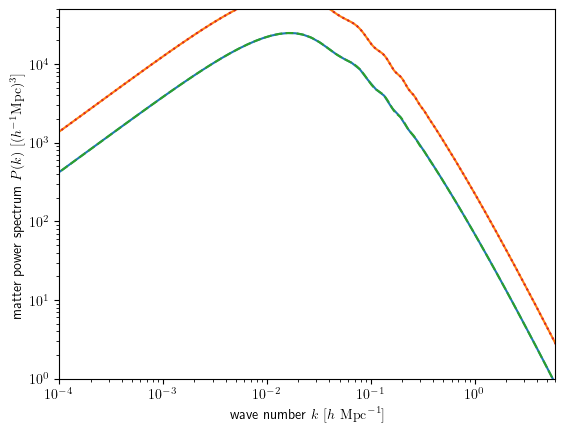

In [48]:
fig,ax = plt.subplots()

ax.plot( kh, pk[0,:] )
ax.plot( kh2, PK[0,:] )
ax.plot( kh2h,PKh[0,:], ls='--')
ax.plot( kh2h,PKh[0,:]/h**3, ls=':' )


#i0=40
#ax.plot( k[:-i0], W_th(k[:-i0],8.)**2*pk[:-i0] )

ax.set_xlim([1.e-4,6.e0])
ax.set_ylim([1.e0,5.e4])

ax.set_xlabel(r'wave number $k$ $[h~\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'matter power spectrum $P(k)$ $[(h^{-1}\mathrm{Mpc})^3]$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

Note that the value of $\sigma_8$ for this power spectrum deviates slightly from that in the _Planck_ 2018 results. I'm guessing this is because each of these parameters comes from different pipelines post-processing the actual data recorded by _Planck_'s instruments, so maybe it is not entirely correct to use them in together like this. The values of $\sigma_8$ for this CAMB power spectrum and from _Planck_ are:

In [22]:
display(Markdown('$\sigma_{{8,\mathrm{{measured}}}} = {0}$'.format( s8[0] )))
display(Markdown('$\sigma_{{8,Planck}} ~~~ = {0}$'.format( sigma_8 )))

$\sigma_{8,\mathrm{measured}} = 0.8226434985679307$

$\sigma_{8,Planck} ~~~ = 0.8111$

It is straightforward to renormalize the power spectrum to a given value of $\sigma_8$, which is what Peak Patch does before loading in the CAMB power spectrum. The variance of the smoothed field is
$$\sigma_R^2 = \frac{1}{2\pi^2} \int_0^\infty \tilde{W}^2(k,R) P(k) k^2 dk$$
where we usually use the real-space top hat kernel, which in Fourier space is a function of the $n=1$ spherical Bessel function of the first kind
$$W_{th,R}(k) = \frac{3j_1(kR)}{kR} = 3 \left( \frac{\sin(kR)}{(kR)^3} - \frac{\cos(kR)}{(kR)^2} \right)$$
this means that if you simply want to rescale $\sigma_R$ to some $\sigma_R' = A \sigma_R$
$$
\sigma_R'^2 = \frac{A^2}{2\pi^2} \int_0^\infty \tilde{W}^2(k,R) P(k) k^2 dk
            = \frac{1}{2\pi^2} \int_0^\infty \tilde{W}^2(k,R) P'(k) k^2 dk
$$
where $P'(k) = A^2 P(k) = \left(\frac{\sigma_R'}{\sigma_R}\right)^2 P(k)$.

## *Peak Patch-WebSky* formatting of power spectra
*Peak Patch* uses a specific normalization scheme. In the script `peakpatch/tools/powersepectrum_create.py`, the power is normalized so measured $\sigma_8$ matches that from *Planck*.

In [4]:
# Normalize matter power spectrum by setting sigma_8 equal to Planck measured value
k  = kh * h                                         # exact wavenumber k, not scaled by h
pk = (sigma_8/s8)**2 * pk[0,:] / ( 2.*np.pi * h)**3 # normalized P_m(z=0,k)
# Note here that we divide by h^3 to get pk in units of Mpc^3

# Primordial zeta power spectrum
ko     = 0.05
pkzeta = 2*np.pi**2*A_s/k**3 * (k/ko)**(n_s-1)

#Get transfer function
T = np.sqrt(pk/pkzeta)

# Read new sigma_8 value
s8 = np.array(results.get_sigma8())

This is the form that *Peak Patch* power spectrum tables take. Once they are read in, we add an additional step, multiplying each power spectrum through by the Fourier-space volume of the box (this is done in `peakpatch/src/modules/RandomField/RandomField.f90`, note that the factor of $(2\pi)^3$ gets multiplied back out again in this step). For a given simulation run with a physical comoving volume $s_\text{box}^3$ modelled by $n^3$ cubic voxels. Such a box contains wave numbers $k \in [ 2 \pi s_\text{box}^{-1} , 2 \pi n s_\text{box}^{-1}]$. The above power spectra $P(k)$ are then convolved with the noise field $\tilde{f}_\text{white noise}(k)$ to make the density field $\bar{\rho}\tilde{\delta}(k) = \sqrt{ V_k P(k) } \tilde{f}_\text{white noise}(k)$.

In [5]:
# physical side length of simulation cube s_box (Mpc)
s_box = 10000.0

# 
n = 10000

# the smallest wave number in this discretization dk (Mpc^-1)
dk = 2*np.pi/s_box

# the largest wave number in this discretization k_max (Mpc^-1)
kmax = n * dk

# Fourier space volume element
d3k = dk**3

# Fourier space volume
V_k = d3k * n**3

# Adding dimension to power spectrum
P_peakpatch = V_k * pk[0,:]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

This picks up a factor of the Fourier space volume $V_k = n^3 d^3k$ at some point in the conversion from a continuous integral to a sum.

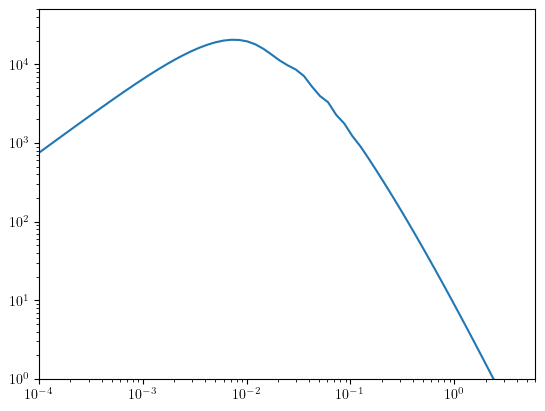

In [14]:
fig,ax = plt.subplots()

ax.plot( k*h, 2*np.pi**2 * pk/h**3 )
#i0=40
#ax.plot( k[:-i0], W_th(k[:-i0],8.)**2*pk[:-i0] )

ax.set_xlim([1.e-4,6.e0])
ax.set_ylim([1.e0,5.e4])

ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

The variance of the smoothed field is
$$\sigma_R^2 = \frac{1}{2\pi^2} \int_0^\infty \tilde{W}^2(k,R) P(k) k^2 dk$$
where we usually use the real-space top hat kernel, which in Fourier space is a function of the $n=1$ spherical Bessel function of the first kind
$$W_{th,R}(k) = \frac{3j_1(kR)}{kR} = 3 \left( \frac{\sin(kR)}{(kR)^3} - \frac{\cos(kR)}{(kR)^2} \right)$$


In [274]:
#fig,ax = plt.subplots()
#ax.loglog(k,pk)

def W_th(k,R):
    return 3 * (np.sin(k*R)/(k*R)**3 - np.cos(k*R)/(k*R)**2)

#fig2,ax2 = plt.subplots()
#ax2.loglog(k,W_th(k,8.)**2)

def sigma(p,k,w,R):
    sig = 0.0
    for i in range(1,len(p)-1,1):
        dk = ( k[i+1] - k[i-1] )/2
        sig += k[i]**2 * p[i] * w(k[i],R)**2 * dk
        #ax.loglog( np.array([ (k[i-1]+k[i])/2 , (k[i-1]+k[i])/2+dk ]) , np.array([p[i],p[i]]) )
    return sig/(2*np.pi**2)

#print(sigma(pk,k,W_th,8.))

dlnP = interpolate.interp1d( np.log10(k) , np.log10(pk), fill_value="extrapolate" )
def power(k):
    return 10.**( dlnP( np.log10(k) ) )

def dsig_dk(k,R):
    return k**2 * W_th(k,R)**2 * power(k) / (2*np.pi**2)

def dsig8_dk(k):
    return k**2 * W_th(k,8.)**2 * power(k) / (2*np.pi**2)

# W^2 has roots at points tanx-x=0, which is periodic with vertical asymptotes at x = j pi/2
# 



#measured_sig8 = integrate.quad(dsig8_dk, k[0], k[-1], limit=100)
#print( measured_sig8 )


The square of the window function `W_th(k,R)` has roots at points $\tan x = x$ (where $x\equiv kR$). The function $\tan x-x$ is periodic with a root at $x=0$ and asymptotes at $x = \frac{(2j-1)\pi}{2}, j\in\mathbb{Z}$. $\tan x-x$ is monotonic between each vertical asymptote, we're only interested in $kR=x>0$ so we therefore have one root on each domain $(\frac{(2j-1)\pi}{2},\frac{(2j+1)\pi}{2}), \forall j\in\mathbb{Z}\cap j>0$.

In [280]:
R_th = 8.

def rootfunc(k,R):
    return np.tan(k*R)-k*R


print( int(np.floor(k[ 0]*R_th/np.pi+.5)) )
print( int(np.floor(k[-1]*R_th/np.pi+.5)) )


# Determine all values of j for which there is an asymptote in the domain ( (2j-1)π/2 , (2j+1)π/2 )
j = np.int64(np.arange( max(int(np.floor(k[ 0]*R_th/np.pi+.5)),1) , int(np.floor(k[-1]*R_th/np.pi+.5)) , 1 ))

# Find roots
include_low=True
include_high=True
if rootfunc(k[0],R_th)>0:
    include_low=False
if rootfunc(k[-1],R_th)<0:
    include_high=False
    
roots = np.zeros( len(j)+include_low+include_high )
if include_low:
    roots[0] = k[0]
if include_high:
    roots[-1] = k[-1]

for i in j:
    klow,khigh = i*np.pi/R_th , (2*i+1)*np.pi/2/R_th

    if rootfunc(khigh,R_th) < 0:
        for q in range(-25,-1):
            if rootfunc(khigh-10.**-q,R_th) > 0:
                khigh=khigh-10.**-q
                break
    
    sol = optimize.root_scalar( rootfunc, R_th, bracket=(klow,khigh) )#, x0=khigh-((j+1)*np.pi*R_th)**-1 )
    
    roots[i-j[0]+include_low] = sol.root

# Integrate
measured_sig8 = 0.
for i in range(len(roots)-1):
    measured_sig8 += (integrate.quad(dsig8_dk, roots[i], roots[i+1], limit=50)[0])
    
print(measured_sig8)

0
2546


/var/folders/hd/5jr7zwrj6bqb_s_l0vgp05w00000gn/T/ipykernel_53536/3505648374.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  measured_sig8 += (integrate.quad(dsig8_dk, roots[i], roots[i+1], limit=50)[0])
/var/folders/hd/5jr7zwrj6bqb_s_l0vgp05w00000gn/T/ipykernel_53536/2727962446.py:22: RuntimeWarning: invalid value encountered in log10
  return 10.**( dlnP( np.log10(k) ) )
/var/folders/hd/5jr7zwrj6bqb_s_l0vgp05w00000gn/T/ipykernel_53536/3505648374.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achie

nan


and simliarly, given a redshift $z$, we can calculate the corresponding comoving distnace $\chi$

In [285]:
rootfunc(99*np.pi/2 + 1.e-14,1)

-156924377115987.2

In [286]:
for i in range(-25,-1,1):
    if rootfunc( 99*np.pi/2 - 10.**i , 1. ) != rootfunc( 99*np.pi/2 , 1. ):
        print (i)
        break
        
print(i)

-13
-13


In [287]:
integrate.quad(dsig8_dk, roots[i], roots[i+1], limit=50)[0]

/var/folders/hd/5jr7zwrj6bqb_s_l0vgp05w00000gn/T/ipykernel_53536/331365755.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(dsig8_dk, roots[i], roots[i+1], limit=50)[0]


0.3467845520721036

In [288]:
os.system('pwd')

/Users/nate/Repositories/peakpatch/python/notebooks


0

Here, I plot the classical, linear-therory matter power spectrum $P(k)$ defined as the Fourier transform of the two-point correlation function $\xi(\mathbf{x},\mathbf{x}',t) \equiv \langle \delta(\mathbf{x},t) \delta(\mathbf{x}',t) \rangle$, where $\langle \cdots \rangle$ is an ensemble average, which on large enough scales is just a volume average $\langle f(\mathbf{x},\mathbf{x}') \rangle \simeq V^{-1} \int f(\mathbf{x},\mathbf{x}') d^3x$, and the overdensity $\delta(\mathbf{x},t)$ is
$$
\delta(\mathbf{x},t)
\equiv
\frac{ \rho(\mathbf{x},t) - \bar{\rho}(t) }{ \bar{\rho}(t) }
=
\int d^3k \tilde{\delta}(\mathbf{k},t) e^{-i \mathbf{k} \cdot \mathbf{x} }
$$
Expaniding the correlation function in Fourier modes gives and defining $\mathbf{x} - \mathbf{x}' = \mathbf{r}$
$$
\begin{align*}
    \xi(\mathbf{x},\mathbf{x}')
    &= V^{-1} \int d^3x \delta(\mathbf{x},t) \delta(\mathbf{x}-\mathbf{r},t)
    \\
    &= V^{-1} \int d^3x \int d^3k \tilde{\mathbf{\delta}}(\mathbf{k},t) e^{-i\mathbf{k}\cdot\mathbf{x}}
       \int d^3k' \tilde{\mathbf{\delta}}(\mathbf{k}',t) e^{-i\mathbf{k}'\cdot(\mathbf{x}-\mathbf{r})}
    \\
    &= V^{-1} \int d^3k \tilde{\delta}(\mathbf{k},t) \int d^3k' \tilde{\delta}(\mathbf{k}',t) e^{i\mathbf{k}'\cdot\mathbf{r}} \int d^3x e^{-i(\mathbf{k}+\mathbf{k}')\cdot\mathbf{x}}
    \\
    &= V^{-1} \int d^3k \tilde{\delta}(\mathbf{k},t) \int d^3k' \tilde{\delta}(\mathbf{k}',t) e^{i\mathbf{k}'\cdot\mathbf{r}} (2\pi)^3 \delta_D^3(\mathbf{k}'+\mathbf{k})
    \\
    &= \frac{(2\pi)^3}{V} \int d^3k \tilde{\delta}(\mathbf{k},t) \tilde{\delta}(-\mathbf{k},t) e^{-i\mathbf{k}\cdot\mathbf{r}}
\end{align*}
$$
For an isotropic and homogeneous field, $\xi(\mathbf{x},\mathbf{x}') = \xi(|\mathbf{x}-\mathbf{x}'|)$, so for vectors $\mathbf{r} = (r,\theta,\phi)$ and $\mathbf{k} = (k,\vartheta,\varphi)$, the correlation function $\xi(\mathbf{x},\mathbf{x}')$ must depend on $r$ only (and not $\theta$, or $\phi$).

$$
(2\pi)^3 P(k) \delta_D^3(\mathbf{k}-\mathbf{k}') = \langle \tilde{\delta}(\mathbf{k})\tilde{\delta}^*(\mathbf{k}')\rangle
$$
where $k = |\mathbf{k}|$ and $\delta_D^3(\mathbf{x})$ is the three-dimensional Dirac delta function.




so

...

$$
= V^{-1} \int_0^\infty dk k^2 \int_0^\pi d\vartheta \sin\vartheta \int_0^{2\pi} d\varphi \tilde{\delta}(\mathbf{k},t) \tilde{\delta}(-\mathbf{k},t) e^{-i\mathbf{k}\cdot\mathbf{r}}
$$